In [2]:
# necessary packages #
#cd("./Documents/Github/Multi_NNGP/RDA/projects/Conj/")
using Distributions
using Random
using Distances
using LinearAlgebra
using SparseArrays
using IterativeSolvers
using ProgressMeter
using JLD2
using DataFrames
using Dates

In [3]:
include("../../../util2.j")

colnorm (generic function with 1 method)

In [4]:
# Packages for diagnostic test #

using StatsPlots
using MCMCChains
using PrettyTables

In [5]:
@load "../../data/conj_data/conj_data_expanded.jld"

┌ Warning: type OrderedCollections.OrderedDict{Symbol,Any} does not exist in workspace; reconstructing
└ @ JLD2 /home/lu/.julia/packages/JLD2/KjBIK/src/data.jl:1153


24-element Array{Symbol,1}:
 :U_indx      
 :S_indx      
 :N           
 :n           
 :m           
 :NN          
 :nnIndx_col  
 :nnIndx_row  
 :NM          
 :MnnIndxLU   
 :MnnIndx     
 :Mnndists    
 :coords      
 :coords_pred 
 :CVNN_train  
 :CVnnIndx_col
 :CVnnIndx_row
 :CVNN_test   
 :CVMnnIndxLU 
 :CVMnnIndx   
 :CVMnndists  
 :parts_train 
 :parts_test  
 :kf          

In [6]:
@load "../../results/conj/conj_resp_results.jld" 

13-element Array{Symbol,1}:
 :N_sam       
 :NM          
 :p           
 :q           
 :β_sam       
 :Σ_sam       
 :Y_m_pos_qt  
 :Y_m_pos_mean
 :Y_m_pos_var 
 :U_indx      
 :Y_ord       
 :α_pick      
 :ϕ_pick      

In [7]:
N

3115934

In [8]:
NM

67132

In [9]:
# CV choose 13 14 15 16#
# (5973.540549 + 5928.378866 + 23569.583394 + 25259.021231)/60

# MCMC Chain check

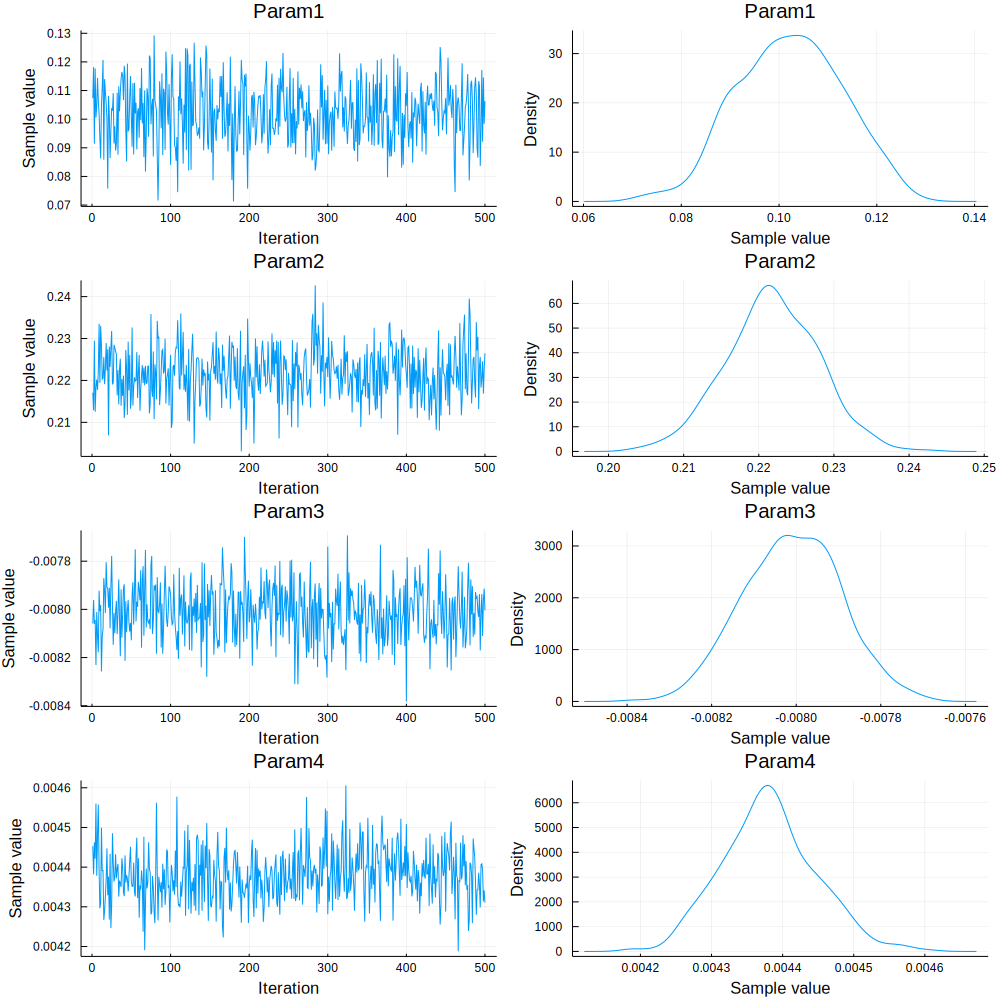

In [10]:
β_pos_sam = Array{Float64, 3}(undef, N_sam, p * q, 1);
β_pos_sam[:, :, 1] = hcat(β_sam[1, 1, :], β_sam[1, 2, :], β_sam[2, 1, :], β_sam[2, 2, :]);
β_chain = Chains(β_pos_sam);
pβ = plot(β_chain)

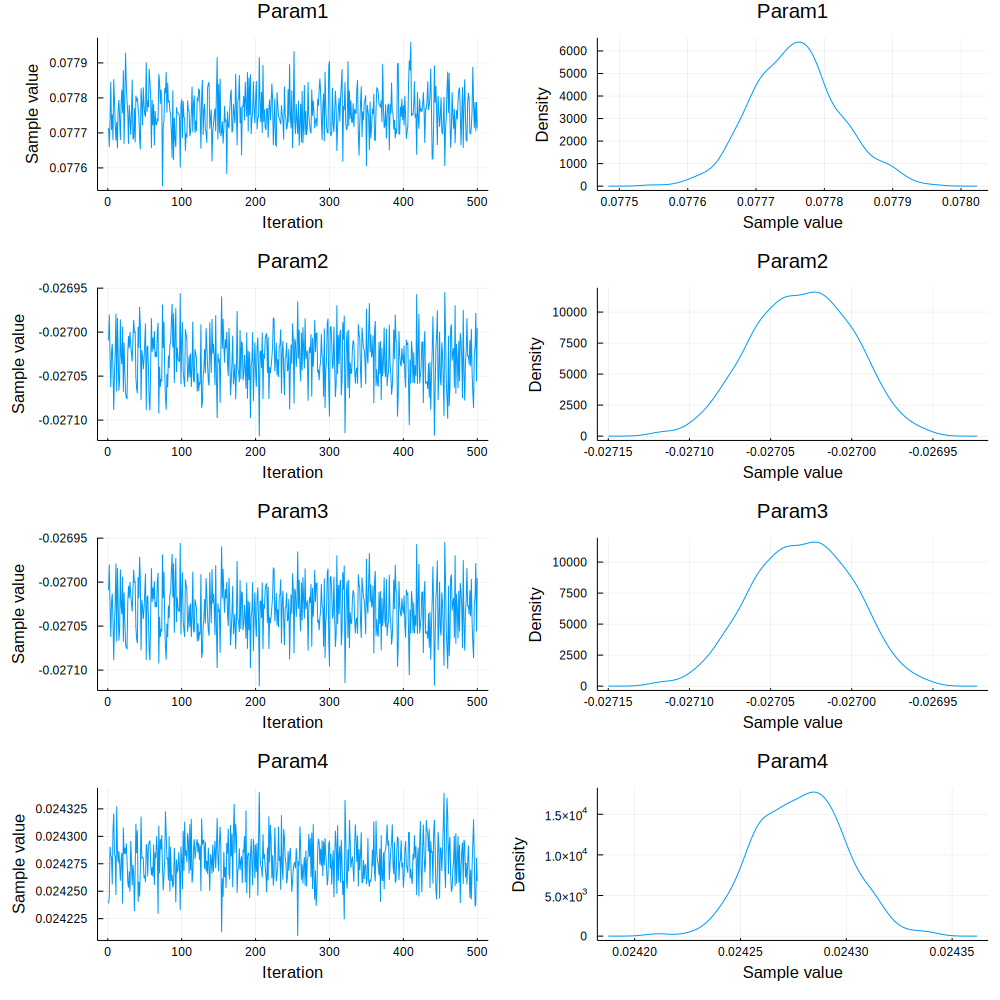

In [11]:
truncindex = 1;#Integer(trunc(N_sam / 2));
Σ_pos_sam = Array{Float64, 3}(undef, N_sam - truncindex + 1, q * q, 1);
Σ_pos_sam[:, :, 1] = hcat(Σ_sam[1, 1, truncindex:N_sam], Σ_sam[1, 2, truncindex:N_sam], 
    Σ_sam[2, 1, truncindex:N_sam], Σ_sam[2, 2, truncindex:N_sam]);
Σ_chain = Chains(Σ_pos_sam);
pΣ = plot(Σ_chain)

# Posterior Inference 

In [12]:

# count the covarage of 95% CI #
count = fill(0.0, 2);
for j in 1:q
    for i in 1:NM
        count[j] = count[j] + 
        ((Y_m_pos_qt[i, j, 1] < Y_ord[U_indx[i], j]) && 
            (Y_m_pos_qt[i, j, 3] > Y_ord[U_indx[i], j]))
    end
end
count

2-element Array{Float64,1}:
 65496.0
 65166.0

In [13]:
round.(count ./ NM, digits = 4)

2-element Array{Float64,1}:
 0.9756
 0.9707

In [14]:
round(sum(count) / (q * NM), digits = 4)

0.9732

In [15]:
# calculate root mean square predictive error #
MSPE1 = mean((Y_ord[U_indx, 1] - Y_m_pos_mean[:, 1]).^2)
RMSPE1 = sqrt(MSPE1); round(RMSPE1, digits = 5)

0.05707

In [16]:
MSPE2 = mean((Y_ord[U_indx, 2] - Y_m_pos_mean[:, 2]).^2)
RMSPE2 = sqrt(MSPE2); round(RMSPE2, digits = 5)

0.03187

In [17]:
# calculate root mean square predictive error #
MSPE = mean((Y_ord[U_indx, :] - Y_m_pos_mean).^2)
RMSPE = sqrt(MSPE); round(RMSPE, digits = 5)

0.04622

In [18]:
round.([RMSPE1 RMSPE2 RMSPE], digits = 5)

1×3 Array{Float64,2}:
 0.05707  0.03187  0.04622

In [19]:
# MAE
MAE1 = mean(abs.(Y_ord[U_indx, 1] - Y_m_pos_mean[:, 1]))
MAE2 = mean(abs.(Y_ord[U_indx, 2] - Y_m_pos_mean[:, 2]))
MAE = mean(abs.(Y_ord[U_indx, :] - Y_m_pos_mean))
round.([MAE1 MAE2 MAE], digits = 5)

1×3 Array{Float64,2}:
 0.03661  0.02191  0.02926

In [20]:
# CRPS
CRPS = [(sqrt(Y_m_pos_var[i, j]) * ( 1 /sqrt(π) - 
        2 * pdf(Normal(), (Y_ord[U_indx[i], j] - Y_m_pos_mean[i, j]) / sqrt(Y_m_pos_var[i, j])) -
        ((Y_ord[U_indx[i], j] - Y_m_pos_mean[i, j]) / sqrt(Y_m_pos_var[i, j])) * 
        (2* cdf(Normal(), (Y_ord[U_indx[i], j] - Y_m_pos_mean[i, j]) / sqrt(Y_m_pos_var[i, j])) - 1 )))
        for i in 1:NM, j in 1:q];
round.([mean(CRPS[:, 1]) mean(CRPS[:, 2]) mean(CRPS)], digits = 5)

1×3 Array{Float64,2}:
 -0.03301  -0.0188  -0.02591

In [21]:
#INT
INT = [((Y_m_pos_qt[i, j, 3] - Y_m_pos_qt[i, j, 1]) + 
    (2 / 0.05)*(Y_m_pos_qt[i, j, 1] - Y_ord[U_indx[i], j]) * (Y_ord[U_indx[i], j] < Y_m_pos_qt[i, j, 1]) + 
    (2 / 0.05)*(Y_ord[U_indx[i], j] - Y_m_pos_qt[i, j, 3]) * (Y_ord[U_indx[i], j] > Y_m_pos_qt[i, j, 3]))
    for i in 1: NM, j in 1:q];
round.([mean(INT[:, 1]) mean(INT[:, 2]) mean(INT)], digits = 5)

1×3 Array{Float64,2}:
 0.42967  0.23564  0.33265

In [22]:
N_Inf_burn = 1;
summary_table = Array{Float64, 2}(undef, 10, 4);
summary_table[1, :] = vcat(mean(β_sam[1, 1, N_Inf_burn:N_sam]),
    quantile(β_sam[1, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[2, :] = vcat(mean(β_sam[1, 2, N_Inf_burn:N_sam]),
    quantile(β_sam[1, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[3, :] = vcat(mean(β_sam[2, 1, N_Inf_burn:N_sam]),
    quantile(β_sam[2, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[4, :] = vcat(mean(β_sam[2, 2, N_Inf_burn:N_sam]),
    quantile(β_sam[2, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[5, :] = vcat( mean(Σ_sam[1, 1, N_Inf_burn:N_sam]),
    quantile(Σ_sam[1, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[6, :] = vcat(mean(Σ_sam[1, 2, N_Inf_burn:N_sam]),
    quantile(Σ_sam[1, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[7, :] = vcat( mean(Σ_sam[2, 2, N_Inf_burn:N_sam]),
    quantile(Σ_sam[2, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[8, :] = vcat( mean((1 / α_pick - 1.0) .* Σ_sam[1, 1, N_Inf_burn:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[1, 1, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[9, :] = vcat(mean((1 / α_pick - 1.0) .* Σ_sam[1, 2, N_Inf_burn:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[1, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table[10, :] = vcat( mean((1 / α_pick - 1.0) .* Σ_sam[2, 2, N_Inf_burn:N_sam]),
    quantile((1 / α_pick - 1.0) .* Σ_sam[2, 2, N_Inf_burn:N_sam], [0.5, 0.025, 0.975]));
summary_table = round.(summary_table; digits = 4);
rnames = ["β[1, 1]", "β[1, 2]", "β[2, 1]", "β[2, 2]", "Σ[1, 1]", "Σ[1, 2]", "Σ[2, 2]",
    "(1/α - 1)Σ[1, 1]", "(1/α - 1)Σ[1, 2]", "(1/α - 1)Σ[2, 2]"];
summary_table = [rnames summary_table];
pretty_table(summary_table,  ["" "mean" "median" "2.5%" "97.5%"], markdown)

|                  |   mean | median |    2.5% |   97.5% |
|------------------|--------|--------|---------|---------|
|          β[1, 1] | 0.1023 | 0.1024 |  0.0822 |  0.1223 |
|          β[1, 2] | 0.2218 | 0.2216 |  0.2094 |  0.2338 |
|          β[2, 1] | -0.008 | -0.008 | -0.0082 | -0.0078 |
|          β[2, 2] | 0.0044 | 0.0044 |  0.0043 |  0.0045 |
|          Σ[1, 1] | 0.0778 | 0.0778 |  0.0776 |  0.0779 |
|          Σ[1, 2] | -0.027 | -0.027 | -0.0271 |  -0.027 |
|          Σ[2, 2] | 0.0243 | 0.0243 |  0.0242 |  0.0243 |
| (1/α - 1)Σ[1, 1] |    0.0 |    0.0 |     0.0 |     0.0 |
| (1/α - 1)Σ[1, 2] |   -0.0 |   -0.0 |    -0.0 |    -0.0 |
| (1/α - 1)Σ[2, 2] |    0.0 |    0.0 |     0.0 |     0.0 |


In [23]:
ϕ_pick

17.918728638037667

In [24]:
α_pick

0.999551052631579